In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
from jax.config import config
from jax.experimental.ode import odeint
config.update("jax_enable_x64", True)

import functools
import neural_tangents as nt
from neural_tangents import stax

def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
root_dir = "beneficial_detrimental/"
ensure_dir(root_dir)

## Define Functions to Compute Theoretical Learning Curves

In [ ]:
# take in 
softmax = jit(lambda a: jnp.exp(a) / jnp.exp(a).sum())

@jit
def kappa_fn(kappa, t, params):
    P, lamb, eigs = params
    return lamb + kappa * jnp.sum( eigs / (eigs * P + kappa) ) - kappa

@jit
def solve_kappa(P, lamb, eigs):
    return odeint(kappa_fn, lamb, jnp.linspace(0.0,250.0, 25), (P,lamb, eigs))[-1]

@jit
def Eg_wrt_test(a, params):
    eigs, phi0, y, P, lamb = params
    sm = softmax(a)

    O = phi0.T @ jnp.diag(sm) @ phi0

    coeffs = 1/y.shape[0] * phi0.T @ y

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum(eigs**2/(eigs* P + kappa)**2)
    Eg_old = kappa**2/(1-gamma) * jnp.sum(coeffs**2 / (eigs*P + kappa)**2)

    f = jnp.sum(jnp.diag(O) * eigs**2/(eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    G_mid = kappa / (kappa + eigs * P) * coeffs
    Eg = Eg_old * f + jnp.dot(G_mid, (O - f*jnp.eye(O.shape[0])) @ G_mid)

    return Eg
grad_wrt_test = grad(Eg_wrt_test)

@jit
def Eg_wrt_train(a, params):
    K, y, P, lamb = params
    sm = softmax(a)

    ## Eigendecomposition of training kernel
    eigs, phi0 = jnp.linalg.eigh(jnp.diag(jnp.sqrt(sm)) @ K @ jnp.diag(jnp.sqrt(sm)))
    phi0 = jnp.diag(1/jnp.sqrt(sm)) @ phi0

    # Compute O wrt uniform distribution
    O = 1/phi0.shape[0]*phi0.T @ phi0

    coeffs = (jnp.diag(sm)@phi0).T @ y

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum( eigs**2 / (eigs* P + kappa)**2 )
    Eg_old = kappa**2 / (1-gamma) * jnp.sum( coeffs**2 / (eigs*P + kappa)**2 )

    f = jnp.sum(jnp.diag(O) * eigs**2/(eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    G_mid = kappa / (kappa + eigs * P) * coeffs
    Eg = Eg_old * f + jnp.dot(G_mid , (O - f*jnp.eye(O.shape[0])) @ G_mid)

    return Eg
grad_wrt_train = jit(grad(Eg_wrt_train))

@jit
def get_O_tilde_wrt_test(prob, params):
    sm = prob
    eigs, phi0, y, P, lamb = params
    O = phi0.T @ jnp.diag(sm) @ phi0

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum(eigs**2 / (eigs*P + kappa)**2 )
    f = jnp.sum(jnp.diag(O) * eigs**2 / (eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    return O - (1-gamma*f)/(1-gamma)*jnp.eye(O.shape[0])

@jit
def get_O_tilde_wrt_train(a, params):
    K, y, P, lamb = params
    sm = softmax(a)

    eigs, phi0 = jnp.linalg.eigh(jnp.diag(jnp.sqrt(sm)) @ K @ jnp.diag(jnp.sqrt(sm)))
    phi0 = jnp.diag(1/jnp.sqrt(sm)) @ phi0

    # Compute O wrt uniform distribution
    O = 1/phi0.shape[0]*phi0.T @ phi0

    kappa = solve_kappa(P, lamb, eigs)
    gamma = P * jnp.sum(eigs**2 / (eigs*P + kappa)**2 )
    f = jnp.sum(jnp.diag(O) * eigs**2 / (eigs*P + kappa)**2)/jnp.sum(eigs**2/(eigs*P + kappa)**2)

    return O - (1-gamma*f)/(1-gamma)*jnp.eye(O.shape[0])


def kr_expt_measure_train(Pvals, prob_dist, K, y, lamb):
    num_repeat = 35
    errs = np.zeros((len(Pvals), num_repeat))
    key = random.PRNGKey(0)
    for n in range(num_repeat):
        for i,P in enumerate(Pvals):
            _, key = random.split(key)
            inds = np.random.choice(K.shape[0], int(P), p = prob_dist, replace = True)
            Ki = K[inds,:]
            Kii = Ki[:,inds]
            yi = y[inds]
            alpha = np.linalg.solve(Kii+lamb*np.eye(int(P)), yi)
            yhat = Ki.T @ alpha
            errs[i,n] = np.mean((yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)


def kr_expt_measure_test(Pvals, prob_dist, K, y, lamb):
    num_repeat = 35
    errs = np.zeros( (len(Pvals), num_repeat) )
    key = random.PRNGKey(0)
    for n in range(num_repeat):
        for i,P in enumerate(Pvals):
            _, key = random.split(key)
            inds = np.random.choice(K.shape[0], int(P), replace = True)
            Ki = K[inds,:]
            Kii = Ki[:,inds]
            yi = y[inds]
            alpha = np.linalg.solve(Kii+lamb*np.eye(int(P)), yi)
            yhat = Ki.T @ alpha
            errs[i,n] = np.sum(prob_dist * (yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)

def nn_expt_measure_train(Pvals, prob_dist, init_fn, apply_fn, X, y):
    num_repeat = 10
    errs = np.zeros((len(Pvals), num_repeat))
    
    opt_init, opt_update, get_params = optimizers.adam(5e-2)
    get_params = jit(get_params)
    opt_update = jit(opt_update)
    
    for i,P in enumerate(Pvals):
        print('P = %d'%P)
        key = random.PRNGKey(0)
        for n in range(num_repeat):
            print('Trial %d'%(n + 1))
            key, subkey = random.split(key)
            _, params = init_fn(subkey, (-1, X.shape[1]))
            opt_state = opt_init(params)

            inds = np.array(random.choice(subkey, K.shape[0], shape = (int(P),), p = prob_dist, replace = True))
            loss_fn = jit(lambda params: jnp.mean((apply_fn(params, X[inds]) - y[inds,jnp.newaxis])**2))
            g_loss = jit(grad(loss_fn))
            
            for t in range(1000):
                opt_state = opt_update(t, g_loss(get_params(opt_state)), opt_state)
                if t % 500 == 0:
                    print(loss_fn(get_params(opt_state)))

            yhat = np.array(apply_fn(get_params(opt_state), X))
            errs[i,n] = np.mean((yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)

def nn_expt_measure_test(Pvals, prob_dist, init_fn, apply_fn, X, y):
    key = random.PRNGKey(0)
    _, params = init_fn(key, (-1, X.shape[1]))
    
    num_repeat = 5
    errs = np.zeros((len(Pvals), num_repeat))
    
    opt_init, opt_update, get_params = optimizers.adam(5e-2)
    get_params = jit(get_params)
    opt_update = jit(opt_update)
    
    for i,P in enumerate(Pvals):
        print('P = %d'%P)
        
        for n in range(num_repeat):
            print('Trial %d'%(n + 1))
            opt_state = opt_init(params)            
            inds = np.random.choice(K.shape[0], int(P), replace = True)
            loss_fn = jit(lambda params: jnp.mean((apply_fn(params, X[inds]) - y[inds,jnp.newaxis])**2))
            g_loss = jit(grad(loss_fn))
            
            for t in range(500):
                opt_state = opt_update(t, g_loss(get_params(opt_state)), opt_state)
                if t % 250 == 0:
                    print(loss_fn(get_params(opt_state)), np.sum(prob_dist))
                    
            yhat = np.array(apply_fn(get_params(opt_state), X))[:,0]
            errs[i,n] = np.sum(prob_dist * (yhat - y)**2)
    return np.mean(errs, axis = 1), np.std(errs, axis = 1)


def mnist_binary(N_tr, a, b, shuffle = False):
    from tensorflow import keras
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  
    inds_binary_train = [i for i in range(len(y_train)) if y_train[i]==a or y_train[i]==b]
    inds_binary_test = [i for i in range(len(y_test)) if y_test[i]==a or y_test[i]==b]

    if shuffle:
        inds_binary_train = np.random.choice(inds_binary_train, size = N_tr, replace = False)
    else:
        inds_binary_train = inds_binary_train[:N_tr]

    x_train = x_train[inds_binary_train]
    y_train = y_train[inds_binary_train]
    x_train = x_train.reshape(N_tr, x_train.shape[1]*x_train.shape[2])
    x_train = x_train.T - np.mean(x_train, axis = 1)
    x_train = (x_train / np.linalg.norm(x_train, axis = 0)).T

    
    x_test = x_test[inds_binary_test]
    y_test = y_test[inds_binary_test]
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    x_test = x_test.T - np.mean(x_test, axis = 1)
    x_test = (x_test / np.linalg.norm(x_test, axis = 0)).T

    y_train = 1.0*(y_train == a) - 1.0*(y_train == b)
    y_test = 1.0*(y_test == a) - 1.0*(y_test == b)

    return (x_train, y_train), (x_test, y_test)

## Download and Preprocess Data

In [ ]:
def fully_connected(width,depth):
    layers = []
    for l in range(depth):
        layers += [stax.Dense(width), stax.Relu()]
    layers += [stax.Dense(1)]
    return stax.serial(*layers)


width=5000
depth = 2
# define a RELU neural tangent kernel
init_fn, apply_fn, kernel_fn = fully_connected(width, depth)
kernel_fn = jit(kernel_fn, static_argnums=(2,))
apply_fn = jit(apply_fn)

# Perform Eigendecomposition to get Eigenvalues and Eigenvectors of the Kernel

### Pick 8's and 9's from MNIST with binary -1,+1 labels. Diagonalize the NTK on the whole dataset.

In [ ]:
a = 9
b = 8
total_pts = 1000
(X, y_vec), (x_test, y_test) = mnist_binary(total_pts, a, b, shuffle = False)

X = jnp.array(X)
y_vec = jnp.array(y_vec)

K = kernel_fn(X, None, 'ntk')

print(y_vec.shape)

eig0, phi0 = jnp.linalg.eigh(1/K.shape[0] * K)
phi0 = jnp.sqrt(K.shape[0]) * phi0
eig0 = jnp.abs(eig0)
psi0 =  phi0 @ jnp.diag(jnp.sqrt(eig0))
## Set the ridge parameter
lamb = 1e-12

# Check if the eigenfunctions are correct.
np.square((K-phi0@jnp.diag(eig0)@phi0.T) - (K-psi0@psi0.T)).mean()

(1000,)


2.6241647725680435e-39

# Optimize Test Measure for Fixed Training Measure

In [ ]:
epoch = 40
Pvals = [10.0]

opt_init, opt_update, get_params = optimizers.adam(0.05)
all_final_ben = []
key = random.PRNGKey(1)

for i, P in enumerate(Pvals):
    opt_state = opt_init(jnp.zeros(K.shape[0]))
    params = (eig0, phi0, y_vec, P, lamb)
    losses = []
    for t in range(epoch):
        losst = Eg_wrt_test(get_params(opt_state), params)
        if t % 5  == 0:
            print("loss %0.5f | participation ratio = %0.5f" % (losst,  1.0/(softmax(get_params(opt_state))**2 ).sum()))
        g = grad_wrt_test(get_params(opt_state), params)
        opt_state = opt_update(t, g, opt_state)
        losses += [losst]
    all_final_ben += [get_params(opt_state)]

opt_init, opt_update, get_params = optimizers.adam(0.05)
all_final_adv = []
key = random.PRNGKey(1)

for i, P in enumerate(Pvals):
    opt_state = opt_init(jnp.zeros(K.shape[0]))
    losses = []
    for t in range(epoch):
        losst = Eg_wrt_test(get_params(opt_state), params)
        if t % 5  == 0:
            print("loss %0.5f | participation ratio = %0.5f" % (losst,  1.0/(softmax(get_params(opt_state))**2 ).sum()))
        g = grad_wrt_test(get_params(opt_state), params)
        opt_state= opt_update(t, -g, opt_state)
        losses += [losst]
    all_final_adv += [get_params(opt_state)]

loss 0.59389 | participation ratio = 1000.00000
loss 0.55474 | participation ratio = 951.84561
loss 0.52161 | participation ratio = 853.47923
loss 0.49448 | participation ratio = 752.98418
loss 0.47232 | participation ratio = 665.93057
loss 0.45379 | participation ratio = 590.70665
loss 0.43785 | participation ratio = 523.37435
loss 0.42376 | participation ratio = 461.72486
loss 0.59389 | participation ratio = 1000.00000
loss 0.63750 | participation ratio = 942.53566
loss 0.68339 | participation ratio = 808.03127
loss 0.73073 | participation ratio = 659.57218
loss 0.77948 | participation ratio = 527.11050
loss 0.82954 | participation ratio = 417.26731
loss 0.88073 | participation ratio = 328.76256
loss 0.93257 | participation ratio = 258.33615


## Make test loss worse

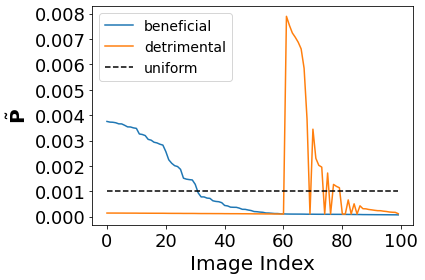

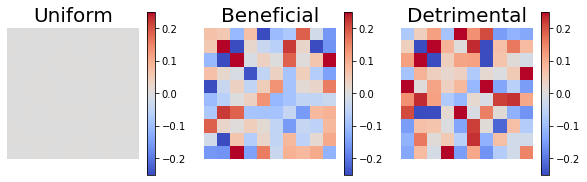

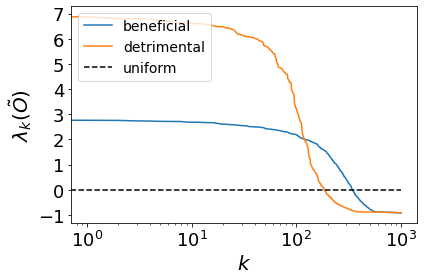

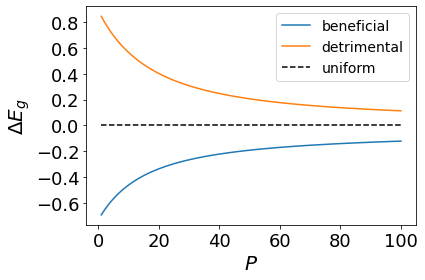

In [ ]:
num_plot = 100
## Turn the logits into probability masses
beneficial = softmax(all_final_ben[0])
adverserial = softmax(all_final_adv[0])
uniform = softmax(jnp.zeros(phi0.shape[0]))

indsort = jnp.argsort(beneficial[0:num_plot])[::-1]

plt.plot(beneficial[0:num_plot][indsort], label = 'beneficial')
plt.plot(adverserial[0:num_plot][indsort], label = 'detrimental')
plt.plot(uniform[0:num_plot][indsort], '--',color = 'black', label = 'uniform')
plt.xlabel(r'Image Index',fontsize = 20)
plt.ylabel(r'$\tilde\mathbf{P}$',fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig(root_dir + 'adv_vs_beneficial_measure.pdf')
plt.show()


# Sort training eigenvalues
indsort = jnp.argsort(eig0)[::-1]

Otilde_adv = get_O_tilde_wrt_test(adverserial,params)[indsort,:][:,indsort]
Otilde_ben = get_O_tilde_wrt_test(beneficial, params)[indsort,:][:,indsort]
Otilde0 = get_O_tilde_wrt_test(uniform, params)[indsort,:][:,indsort]

plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
plt.title('Uniform',fontsize=20)
plt.imshow(Otilde0[0:10,0:10], vmin =-0.25, vmax = 0.25, cmap ='coolwarm')
plt.axis('off')
plt.colorbar()
plt.ylabel(r'$\tilde{O}$',fontsize = 20)
plt.subplot(1,3,2)
plt.imshow(Otilde_ben[0:10,0:10], vmin =-0.25, vmax = 0.25, cmap = 'coolwarm')
plt.axis('off')
plt.colorbar()
plt.title('Beneficial',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(Otilde_adv[0:10,0:10], vmin =-0.25, vmax = 0.25, cmap = 'coolwarm')
plt.axis('off')
plt.colorbar()
plt.title('Detrimental',fontsize=20)
plt.savefig(root_dir + 'O_tilde_visual.pdf')
plt.show()

Oeigs0, V0_tilde = jnp.linalg.eigh(Otilde0)
Oeigs_adv, V_tilde_adv = jnp.linalg.eigh(Otilde_adv)
Oeigs_ben, V_tilde_ben = jnp.linalg.eigh(Otilde_ben)

plt.semilogx(Oeigs_ben[::-1], label = 'beneficial')
plt.semilogx(Oeigs_adv[::-1], label = 'detrimental')
plt.semilogx(Oeigs0, '--',color = 'black', label = 'uniform')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 14)
plt.ylabel(r'$\lambda_k( \tilde{O} )$',fontsize=20)
plt.xlabel(r'$k$',fontsize=20)
plt.tight_layout()
plt.savefig(root_dir + 'O_tilde_spectra_visual.pdf')
plt.show()


Pvals = jnp.linspace(1,100,100)
errs1 = []
errs2 = []
for i,P in enumerate(Pvals):
    coeffs = 1/phi0.shape[0] * phi0.T @ y_vec
    v = coeffs * (eig0*P + 1e-3)**(-1)
    errs1 += [ 1/phi0.shape[0]**2 * v.T @ Otilde_adv @ v ]
    errs2 +=  [ 1/phi0.shape[0]**2 * v.T @ Otilde_ben @ v ]
    

plt.plot(Pvals,errs1, label = 'beneficial')
plt.plot(Pvals,errs2, label = 'detrimental')
plt.plot(Pvals, jnp.zeros(len(Pvals)),'--',color = 'black',label = 'uniform')
plt.xlabel(r'$P$',fontsize = 20)
plt.ylabel(r'$\Delta E_g$',fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig(root_dir + 'quadratic_form_P.pdf')
plt.show()

## Perform Kernel Regression and Train Wide Neural Network to Test on the New Test Distribution.

In [ ]:
loss_ben = jnp.array([Eg_wrt_test(all_final_ben[0], (eig0, phi0, y_vec, P, lamb)) for P in Pvals])
loss_adv = jnp.array([Eg_wrt_test(all_final_adv[0], (eig0, phi0, y_vec, P, lamb)) for P in Pvals])
loss_uni = jnp.array([Eg_wrt_test(jnp.zeros(y_vec.shape[0]), (eig0, phi0, y_vec, P, lamb)) for P in Pvals])
Pvals_expt = np.linspace(5, 100, 10)

print('Kernel Regression for Beneficial')
err_ben, std_ben = kr_expt_measure_test(Pvals_expt, beneficial, K, y_vec, lamb)
print('Kernel Regression for Adverserial')
err_adv, std_adv = kr_expt_measure_test(Pvals_expt, adverserial, K, y_vec, lamb)
print('Kernel Regression for Uniform')
err_uni, std_uni = kr_expt_measure_test(Pvals_expt, uniform, K, y_vec, lamb)

print('NN Experiment for Beneficial')
err_ben_nn, std_ben_nn = nn_expt_measure_test(Pvals_expt, beneficial, init_fn, apply_fn, X, y_vec)
print('NN Experiment for Adverserial')
err_adv_nn, std_adv_nn = nn_expt_measure_test(Pvals_expt, adverserial, init_fn, apply_fn, X, y_vec)
print('NN Experiment for Uniform')
err_uni_nn, std_uni_nn = nn_expt_measure_test(Pvals_expt, uniform, init_fn, apply_fn, X, y_vec)

np.savez(root_dir + 'data.npz', loss_ben, loss_adv, 
         loss_uni, Pvals_expt, err_ben, std_ben, err_adv, std_adv,
         err_uni, std_uni, err_ben_nn, std_ben_nn, err_adv_nn, std_adv_nn, err_uni_nn, std_uni_nn)

Kernel Regression for Beneficial
Kernel Regression for Adverserial
Kernel Regression for Uniform
NN Experiment for Beneficial
P = 5
Trial 1
0.2950836468699272 1.0
5.733328714820643e-13 1.0
Trial 2
0.23587240471093357 1.0
8.948357586355832e-13 1.0
Trial 3
0.24731968089994083 1.0
1.149378004830936e-13 1.0
Trial 4
0.17056018335040424 1.0
8.148813954287815e-13 1.0
Trial 5
0.38060597362450227 1.0
2.1789841781276913e-13 1.0
P = 15
Trial 1
0.2060609947948837 1.0
6.122339928100932e-13 1.0
Trial 2
0.5637652982427475 1.0
4.0885314992813764e-13 1.0
Trial 3
0.28509250235407463 1.0
9.127208268494844e-13 1.0
Trial 4
0.27371832001426843 1.0
7.819083649559244e-13 1.0
Trial 5
0.2372898049880891 1.0
3.92157845286393e-13 1.0
P = 26
Trial 1
0.2323825279862798 1.0
1.368928131140557e-12 1.0
Trial 2
0.5986304458125502 1.0
3.5288791923588004e-13 1.0
Trial 3
0.2689808410931985 1.0
3.2843700215680094e-13 1.0
Trial 4
0.8566531218808406 1.0
3.768694616936795e-13 1.0
Trial 5
0.1932169540558085 1.0
1.22660924529634

NameError: name 'std_0' is not defined

In [ ]:
data = np.load(root_dir + 'data.npz', allow_pickle=True)

loss_ben, loss_adv, \
loss_uni, Pvals_expt, err_ben, std_ben, err_adv, std_adv, \
err_uni, std_uni, err_ben_nn, std_ben_nn, \
err_adv_nn, std_adv_nn, err_uni_nn, std_uni_nn = [data['arr_%i'%i] for i in range(len(data))]

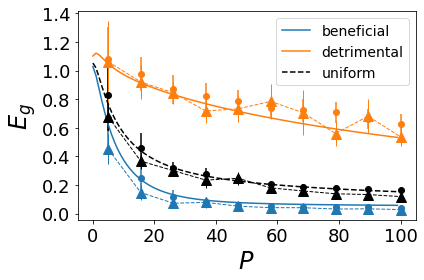

In [ ]:
plt.plot(loss_ben, label = 'beneficial')
plt.plot(loss_adv, label = 'detrimental')
plt.plot(loss_uni, '--',color = 'black',  label = 'uniform')
plt.errorbar(Pvals_expt, err_ben, std_ben , fmt='o', color = 'C0')
plt.errorbar(Pvals_expt, err_adv, std_adv ,fmt='o', color = 'C1')
plt.errorbar(Pvals_expt, err_uni, std_uni, fmt = 'o', color = 'black')

plt.errorbar(Pvals_expt, err_ben_nn, std_ben_nn, fmt='--^', color = 'C0', linewidth=1, markersize=10)
plt.errorbar(Pvals_expt, err_adv_nn, std_adv_nn ,fmt='--^', color = 'C1', linewidth=1, markersize=10)
plt.errorbar(Pvals_expt, err_uni_nn, std_uni_nn, fmt = '--^', color = 'black', linewidth=1, markersize=10)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.xlabel(r'$P$',fontsize = 24)
plt.ylabel(r'$E_g$',fontsize = 24)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig(root_dir + 'change_test_lc.pdf')
plt.show()

# Optimize Training Measure for Fixed Test Distribution

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(0.15)

Pvals = [10.0, 25.0, 50.0, 1000.0]
all_final = []
key = random.PRNGKey(1)
for i, P in enumerate(Pvals):
    params = (K, y_vec, P, lamb)
    opt_state = opt_init(jnp.zeros(K.shape[0]))
    T = 40
    losses = []
    print("P = %d" % P)
    for t in range(T):
        losst = Eg_wrt_train(get_params(opt_state), params)
        if t % (T // 4)  == 0:
            print("loss %0.5f | participation ratio = %0.5f" % (losst,  1.0/(softmax(get_params(opt_state))**2 ).sum()) )
        g = grad_wrt_train(get_params(opt_state), params)
        opt_state= opt_update(t, g , opt_state)
        losses += [losst]

    all_final += [get_params(opt_state)]


P = 10
loss 0.59389 | participation ratio = 1000.00000
loss 0.50735 | participation ratio = 595.81220
loss 0.48307 | participation ratio = 357.65815
loss 0.46532 | participation ratio = 169.35359
P = 25
loss 0.33806 | participation ratio = 1000.00000
loss 0.28776 | participation ratio = 580.89875
loss 0.26791 | participation ratio = 311.90290
loss 0.25937 | participation ratio = 202.14913
P = 50
loss 0.22328 | participation ratio = 1000.00000
loss 0.18042 | participation ratio = 514.10305
loss 0.16355 | participation ratio = 282.52917
loss 0.14998 | participation ratio = 136.54369
P = 1000
loss 0.00000 | participation ratio = 1000.00000
loss 0.00000 | participation ratio = 999.89300
loss 0.00000 | participation ratio = 999.56456
loss 0.00000 | participation ratio = 999.01207


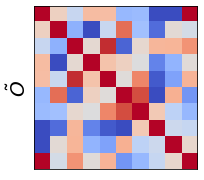

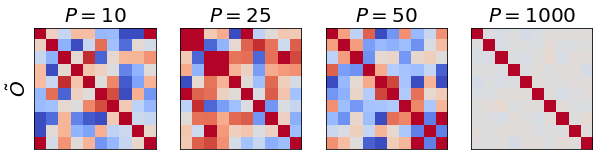

In [ ]:
indsort = jnp.argsort(eig0)[::-1]

Oi = get_O_tilde_wrt_train(all_final[0], params)[indsort,:][:,indsort]

plt.figure(figsize = (3,3))
plt.imshow(Oi[0:10,0:10], vmin =-0.1, vmax = 0.1, cmap ='coolwarm')
plt.xticks([])
plt.yticks([])
plt.ylabel(r'$\tilde{O}$',fontsize = 20)
plt.savefig(root_dir + 'tilde_O_P10_opt_train.pdf')
plt.show()

plt.figure(figsize = (10,3))
for i,P in enumerate(Pvals):
    Oi = get_O_tilde_wrt_train(all_final[i], params)[indsort,:][:,indsort]

    plt.subplot(1,len(Pvals), i+1)
    plt.imshow(Oi[0:10,0:10], vmin =-0.1, vmax = 0.1, cmap ='coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.title(r'$P = %d$' % P,fontsize=20)
    if i ==0:
        plt.ylabel(r'$\tilde{O}$',fontsize = 20)
plt.savefig(root_dir + 'tilde_O_vary_P_opt_train.pdf')
plt.show()

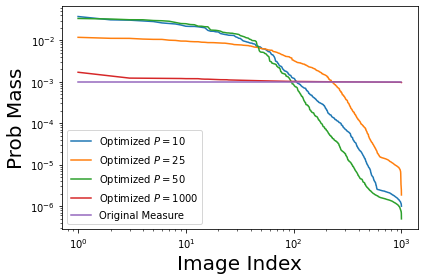

In [ ]:
for i, P in enumerate(Pvals):
    plt.loglog(np.linspace(1,len(all_final[i]), len(all_final[i])), softmax(all_final[i]).sort()[::-1], label =r'Optimized $P = %d$' % P )
plt.loglog(np.linspace(1,len(all_final[i]), len(all_final[i])), 1e-3 * np.ones(len(all_final[i] )), label = 'Original Measure')

plt.legend()

plt.xlabel('Image Index',fontsize = 20)
plt.ylabel(r'Prob Mass', fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'optimized_training_dist_longer.pdf')
plt.show()

/n/home12/canatara/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4771: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


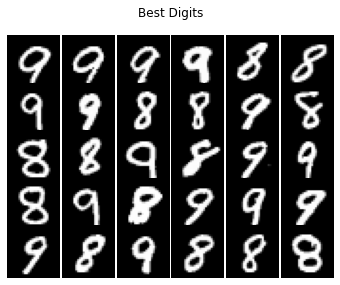

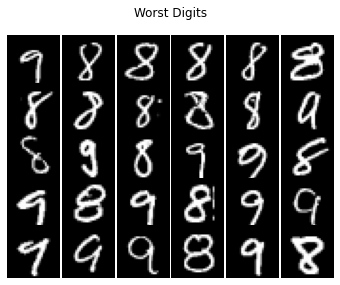

In [ ]:
indmax = np.argmax(softmax(all_final[1]))
indsort = np.argsort(softmax(all_final[1]))[::-1]

axs =[plt.subplot(5,6,i+1) for i in range(30)]
for j, a in enumerate(axs):
    a.imshow(X[indsort[j]].reshape((28,28)), cmap = 'gray')
    a.axis('off')
plt.suptitle('Best Digits')
plt.tight_layout()
plt.subplots_adjust(wspace = -0.6,hspace=-0.1)
plt.savefig(root_dir + 'best_digits_longer.pdf')
plt.show()

axs =[plt.subplot(5,6,i+1) for i in range(30)]
for j, a in enumerate(axs):
    a.imshow(X[inds_back[j]].reshape((28,28)), cmap = 'gray')
    a.axis('off')
plt.suptitle('Worst Digits')
plt.tight_layout()
plt.subplots_adjust(wspace = -0.6,hspace=-0.1)
plt.savefig(root_dir + 'worst_digits_longer.pdf')
plt.show()


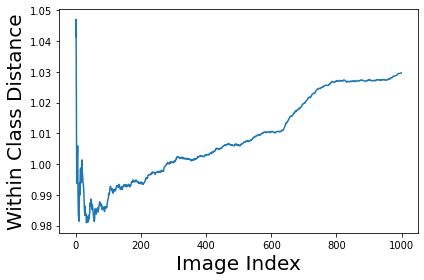

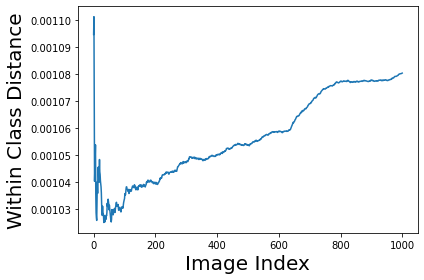

In [ ]:
X01 = X

G = X01 @ X01.T
D = np.sqrt(np.outer( np.diag(G), np.ones(G.shape[0]) ) + np.outer(np.ones(G.shape[0]),  np.diag(G) ) - 2 * G )

ans = np.zeros(D.shape[0])
opp = np.zeros(D.shape[0])
for i in range(D.shape[0]):
    yi = y_vec[i]
    ans[i] = D[i, y_vec == yi].mean()
    opp[i] = D[i, y_vec != yi].mean()

plt.plot( np.cumsum( ans[indsort]) / np.linspace(1,1000, 1000)  )
plt.xlabel('Image Index',fontsize = 20)
plt.ylabel('Within Class Distance',fontsize =20)
plt.tight_layout()
plt.show()

Psi_Dist = jnp.diag(K)[:,jnp.newaxis] + jnp.diag(K)[jnp.newaxis,:] - 2*K

for i in range(Psi_Dist.shape[0]):
    yi = y_vec[i]
    ans[i] = Psi_Dist[i, y_vec == yi].mean()

plt.plot( np.cumsum( ans[indsort]) / np.linspace(1,1000, 1000))
plt.xlabel('Image Index',fontsize = 20)
plt.ylabel('Within Class Distance',fontsize =20)
plt.tight_layout()
plt.show()

In [ ]:
Pvals_expt = np.linspace(5, 100, 10)
Pvals_dense = np.linspace(0, 100, 40)

all_expt_avg = []
all_expt_std = []

all_theory = []

err_old,std_old = kr_expt_measure_train(Pvals_expt, np.ones(K.shape[0])/K.shape[0], K, y_vec, lamb)
theory_curves_old = [Eg_wrt_train(jnp.ones(K.shape[0]), (K, y_vec, P, lamb) ) for P in Pvals_dense]

for i, state in enumerate(all_final):
    err_new, std_new = kr_expt_measure_train(Pvals_expt, np.array(softmax(state)), K, y_vec, lamb)
    theory_curves = [Eg_wrt_train(state, (K, y_vec, P, lamb) ) for P in Pvals_dense]
    all_expt_avg += [err_new]
    all_expt_std += [std_new]
    all_theory += [theory_curves]


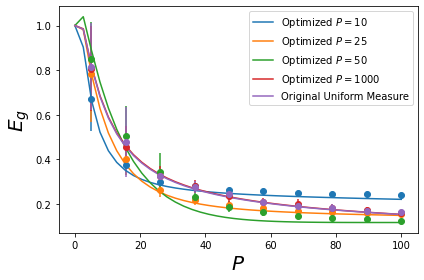

In [ ]:
for i, theory_i in enumerate(all_theory):
    plt.plot(Pvals_dense, np.array(theory_i), color = 'C%d' % i, label =r'Optimized $P = %d$' % Pvals[i] )
    plt.errorbar(Pvals_expt, all_expt_avg[i], all_expt_std[i], fmt='o', color = 'C%d' % i )

plt.plot(Pvals_dense, np.array(theory_curves_old), color = 'C%d' % (i+1), label = 'Original Uniform Measure')
plt.errorbar(Pvals_expt, err_old, std_old, fmt='o' , color = 'C%d' % (i+1))
plt.xlabel(r'$P$',fontsize = 20)
plt.ylabel(r'$E_g$', fontsize=20)
plt.legend()

plt.tight_layout()
plt.show()

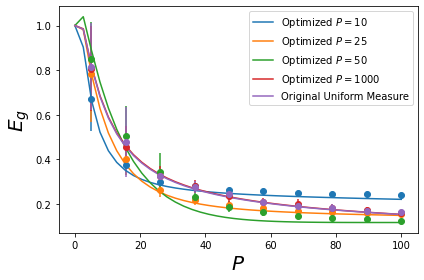

In [ ]:
for i, theory_i in enumerate(all_theory):
    plt.plot(Pvals_dense, np.array(theory_i), color = 'C%d' % i, label =r'Optimized $P = %d$' % Pvals[i] )
    plt.errorbar(Pvals_expt, all_expt_avg[i], all_expt_std[i], fmt='o', color = 'C%d' % i )

plt.plot(Pvals_dense, np.array(theory_curves_old), color = 'C%d' % (i+1), label = 'Original Uniform Measure')
plt.errorbar(Pvals_expt, err_old, std_old, fmt='o' , color = 'C%d' % (i+1))
plt.xlabel(r'$P$',fontsize = 20)
plt.ylabel(r'$E_g$', fontsize=20)
plt.legend()

plt.tight_layout()
plt.show()

## Neural Network Experiment

In [ ]:
Pvals_expt = np.linspace(5, 100, 10)

width = 2000
depth = 2

init_fn, apply_fn, kernel_fn = fully_connected(width, depth)
_, params = init_fn(random.PRNGKey(0), (-1, X.shape[1]))
opt_init,opt_update,get_params = optimizers.adam(1e-3)


def train(loss, gloss, opt_state):
    for t in range(400):
        opt_state = opt_update(t, gloss(get_params(opt_state)), opt_state)
    return opt_state

def nn_expt(Pvals_expt, prob_dist):
    num_repeat = 10
    errs = np.zeros((len(Pvals_expt), num_repeat))
    for i, P in enumerate(Pvals_expt):
        print("P = %d" % P)
        for j in range(num_repeat):
            opt_state = opt_init(params)
            inds = np.random.choice(K.shape[0], int(P), p = prob_dist, replace = True)
            loss = jit(lambda theta: jnp.mean((apply_fn(theta, X[inds,:]) - y_vec[inds,jnp.newaxis])**2))
            gloss = jit(grad(loss))
            opt_state = train(loss, gloss, opt_state)
            errs[i,j] = jnp.mean((apply_fn(get_params(opt_state), X)- y_vec[:,jnp.newaxis])**2)
    return jnp.mean(errs, axis = 1), jnp.std(errs, axis = 1)

errs_uni, stds_uni = nn_expt(Pvals_expt, np.ones(K.shape[0])/K.shape[0])
all_errs_nn, all_stds_nn = [], []

for i, state in enumerate(all_final):
    errsi, stdsi = nn_expt(Pvals_expt, np.array(softmax(state)))
    all_errs_nn += [errsi]
    all_stds_nn += [stdsi]


(1000, 1)
(1000,)
P = 5
P = 15
P = 26
P = 36
P = 47
P = 57
P = 68
P = 78
P = 89
P = 100
P = 5
P = 15
P = 26
P = 36
P = 47
P = 57
P = 68
P = 78
P = 89
P = 100
P = 5
P = 15
P = 26
P = 36
P = 47
P = 57
P = 68
P = 78
P = 89
P = 100
P = 5
P = 15
P = 26
P = 36
P = 47
P = 57
P = 68
P = 78
P = 89
P = 100
P = 5
P = 15
P = 26
P = 36
P = 47
P = 57
P = 68
P = 78
P = 89
P = 100


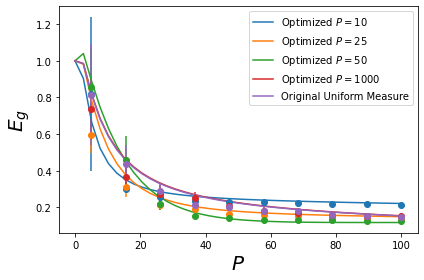

In [ ]:
for i, theory_i in enumerate(all_theory):
    plt.plot(Pvals_dense, np.array(theory_i), color = 'C%d' % i, label =r'Optimized $P = %d$' % Pvals[i] )
    plt.errorbar(Pvals_expt, all_errs_nn[i], all_stds_nn[i], fmt='o', color = 'C%d' % i )

plt.plot(Pvals_dense, np.array(theory_curves_old), color = 'C%d' % (i+1), label = 'Original Uniform Measure')
plt.errorbar(Pvals_expt, errs_uni, stds_uni, fmt='o' , color = 'C%d' % (i+1))
plt.xlabel(r'$P$',fontsize = 20)
plt.ylabel(r'$E_g$', fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'nn_learning_curve_optimized_measure_longer.pdf')
plt.show()